<a href="https://colab.research.google.com/github/vit050587/Natural_Language_Processing/blob/master/KVA_HW_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 4. Домашнее задание.
**Тематическое моделирование. EM-алгоритм**

объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
сделать визуализацию кластеров тематик
проинтерпритировать получившиеся тематики

In [1]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 39.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=da289c1661c8c1cee4f60f0e4047e2567127de07214284cb2c64f0449cf26e75
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
import requests
from bs4 import BeautifulSoup
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import re
import string
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize

In [3]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/Lesson02/positive.csv', sep=';', usecols=[3], names=['text'])
#positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/Lesson02/positive.csv', sep=';', usecols=[3], names=['text'])
#negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

<ipython-input-3-1468bc8fa89b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = positive.append(negative)


In [4]:
df

,text
0,"@first_timee хоть я и школота, но поверь, у на..."
1,"Да, все-таки он немного похож на него. Но мой ..."
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3,"RT @digger2912: ""Кто то в углу сидит и погибае..."
4,@irina_dyshkant Вот что значит страшилка :D\nН...
...,...
114906,"Спала в родительском доме, на своей кровати......"
114907,RT @jebesilofyt: Эх... Мы немного решили сокра...
114908,"Что происходит со мной, когда в эфире #proacti..."
114909,"""Любимая,я подарю тебе эту звезду..."" Имя како..."


In [5]:
nltk.download('stopwords')
words_regex = re.compile('\w+')
morph = MorphAnalyzer()
my_stopwords = ['здравствуйте', 'добрый', 'день', 'вопрос', 'роспотребнадзор', 'либо', 'месяц',
                'течение', 'данный', 'это', 'просить', 'сказать', 'год', 'адрес', 'обращение', 'мочь', 'иметь', 'человек',
                'право', 'санкт' ,'петербург']

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian') + my_stopwords

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df.text.iloc[1]

'Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D'

In [7]:
print(preprocess(df.text.iloc[1]))

['всё', 'таки', 'немного', 'похожий', 'мальчик', 'всё', 'равно', 'хороший']


In [8]:
preprocessed_text = list(tqdm(map(preprocess, df['text']), total=len(df)))

  0%|          | 0/229822 [00:00<?, ?it/s]

In [9]:
df['preprocessed_text'] = preprocessed_text
df.sample(3)

,text,preprocessed_text
46465,"@KrilovaValeria мы таааак ""любим"" соционику, ч...","[krilovavaleria, таааак, любим, соционик, гото..."
97520,@ZurabChitaya @KomandaCom Карасёв в D-лиге - с...,"[zurabchitaya, komandacom, карасёвый, лига, ра..."
114448,"@Ann_Kurakina ..это из той же оперы, что в чат...","[опера, чат, курятник, всё, пройти, печаль, ра..."


# Модель LDA

Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim

In [10]:
!pip install -U gensim

In [11]:
from gensim.models import *
from gensim import corpora

In [12]:
dictionary = corpora.Dictionary(df['preprocessed_text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря
dictionary.save('/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/Lesson04/texts.dict')

In [13]:
corpus = [dictionary.doc2bow(text) for text in df['preprocessed_text']]
corpora.MmCorpus.serialize('texts.model', corpus)

In [14]:
%time
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=2)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


In [15]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.091*"сегодня" + 0.069*"хотеть" + 0.035*"ждать" + 0.031*"пойти" + 0.026*"предновогодниеобнимашка" + 0.021*"нравиться" + 0.016*"наверное" + 0.016*"скоро" + 0.016*"место" + 0.016*"музыка"'),
 (1,
  '0.057*"завтра" + 0.042*"смотреть" + 0.037*"думать" + 0.032*"первый" + 0.030*"идти" + 0.029*"любимый" + 0.021*"мама" + 0.020*"молодёжка" + 0.019*"найти" + 0.017*"школа"'),
 (2,
  '0.175*"всё" + 0.025*"писать" + 0.019*"посмотреть" + 0.016*"таки" + 0.014*"приятно" + 0.014*"сон" + 0.014*"давно" + 0.014*"стать" + 0.012*"получить" + 0.012*"никто"'),
 (3,
  '0.092*"ещё" + 0.036*"большой" + 0.028*"ахи" + 0.021*"дом" + 0.019*"ахах" + 0.019*"хотя" + 0.018*"сидеть" + 0.016*"почему" + 0.016*"твит" + 0.016*"нибыть"'),
 (4,
  '0.093*"просто" + 0.029*"давать" + 0.022*"пара" + 0.018*"привет" + 0.017*"крутой" + 0.014*"твиттер" + 0.013*"пройти" + 0.013*"рождение" + 0.012*"любовь" + 0.012*"хах"'),
 (5,
  '0.064*"знать" + 0.059*"любить" + 0.040*"делать" + 0.031*"твой" + 0.030*"спать" + 0.030*"сделать" +

In [16]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 31.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.
tensorflow 2.12.0 

In [17]:
!pip install pyLDAvis

ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim_models (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim_models


In [28]:
!pip install pandas==1.5.3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 35.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.0
    Uninstalling pandas-2.0.0:
      Successfully uninstalled pandas-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [30]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
%%time
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 18.5 s, sys: 511 ms, total: 19 s
Wall time: 43.5 s


Заносить слова в стоп-лист можно бесконечно))

In [20]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Персплексия:  6.599296900911668e-05


In [21]:
CoherenceModel(model=lda, texts=df['preprocessed_text'], dictionary=dictionary, coherence='u_mass').get_coherence()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-6.475988121517558

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/23 [00:00<?, ?it/s]

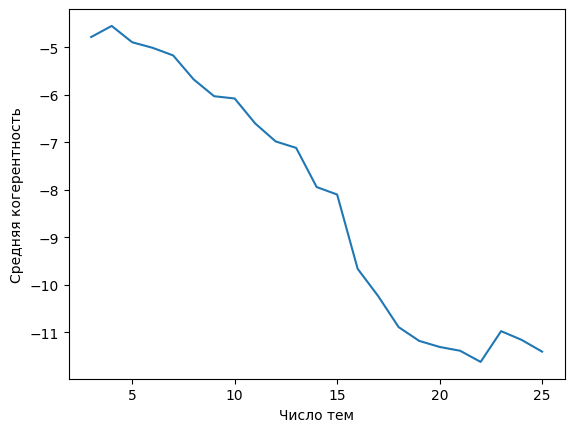

In [22]:
topics_list = list(range(3, 26))
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=150, update_every=1, passes=3)
    coherences.append(CoherenceModel(model=lda, texts=df['preprocessed_text'], dictionary=dictionary, coherence='u_mass').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Выбираю оптимальным делить вопросы на 6 тем.

In [32]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=6, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
vis_data.topic_info.Category

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


15      Default
6       Default
143     Default
18      Default
12      Default
         ...   
1633     Topic6
1002     Topic6
1007     Topic6
2562     Topic6
1606     Topic6
Name: Category, Length: 213, dtype: object

In [34]:
topic_names_list = vis_data.topic_info.Category.unique()
topic_names_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Default', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5',
       'Topic6'], dtype=object)

In [35]:
for topic_name in topic_names_list[1:]:
  print(list(vis_data.topic_info.loc[vis_data.topic_info.Category == topic_name].Term[:8]))

['http', 'весь', 'сегодня', 'новый', 'пятница', 'твой', 'ждать', 'ночь']
['ещё', 'который', 'ахи', 'пойти', 'наш', 'жизнь', 'пока', 'время']
['просто', 'свой', 'любить', 'хотеть', 'делать', 'спать', 'написать', 'мама']
['спасибо', 'очень', 'думать', 'говорить', 'друг', 'сделать', 'писать', 'вечер']
['знать', 'завтра', 'вообще', 'первый', 'идти', 'любимый', 'давать', 'посмотреть']
['хороший', 'смотреть', 'самый', 'большой', 'дом', 'нужно', 'купить', 'пара']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
